In [2]:
from nufeb_tools import utils,plot,spatial
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
#import skgeom as sg
from tqdm import tqdm
from pathlib import Path
import dask
from dask import dataframe as dd
from joblib import Parallel, delayed
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
#BASE_DIR = Path(f'../simulation-data/runs')
#folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
#subset = folders[:50]
#test_folders = [r'D:\runs\Run_50_50_10_1_2021-07-27',r'D:\runs\Run_50_50_45_1_2021-07-27',r'D:\runs\Run_50_50_100_1_2021-07-27']
CADES_DIR = Path(f'/lustre/or-scratch/cades-cnms/12x/NUFEB/runs')
CADES_folders = [path for path in CADES_DIR.iterdir() if path.is_dir()]


In [4]:
# Load datasets one at a time
#data = [utils.get_data(directory=str(folder)) for folder in sorted(CADES_folders)[:50]]

# Gather datasets

In [5]:
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return

with Parallel(n_jobs=-1) as parallel:
    temp = parallel(delayed(collect_data)(folder) for folder in tqdm(sorted(CADES_folders)))
data = pd.concat(temp)
data.to_pickle('saved-metrics.pkl')

 51%|█████     | 512/1000 [2:02:38<3:01:33, 22.32s/it]/software/dev_tools/swtree/cs400_centos7.2_pe2016-08/anaconda3/5.1.0/centos7.2_gnu6.3.0/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
100%|██████████| 1000/1000 [7:51:06<00:00, 28.27s/it] 


# Preliminary multiple linear regression

In [6]:
metric2 = data[data.type==2].fillna(0)
import statsmodels.api as sm
metric_list = list(metric2.columns.drop('total biomass'))
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 7.699e+04
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:16:58   Log-Likelihood:            -5.5060e+05
No. Observations:               45935   AIC:                         1.101e+06
Df Residuals:                   45916   BIC:                         1.101e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
mother_cell             

# Plot all possible metrics vs biomass

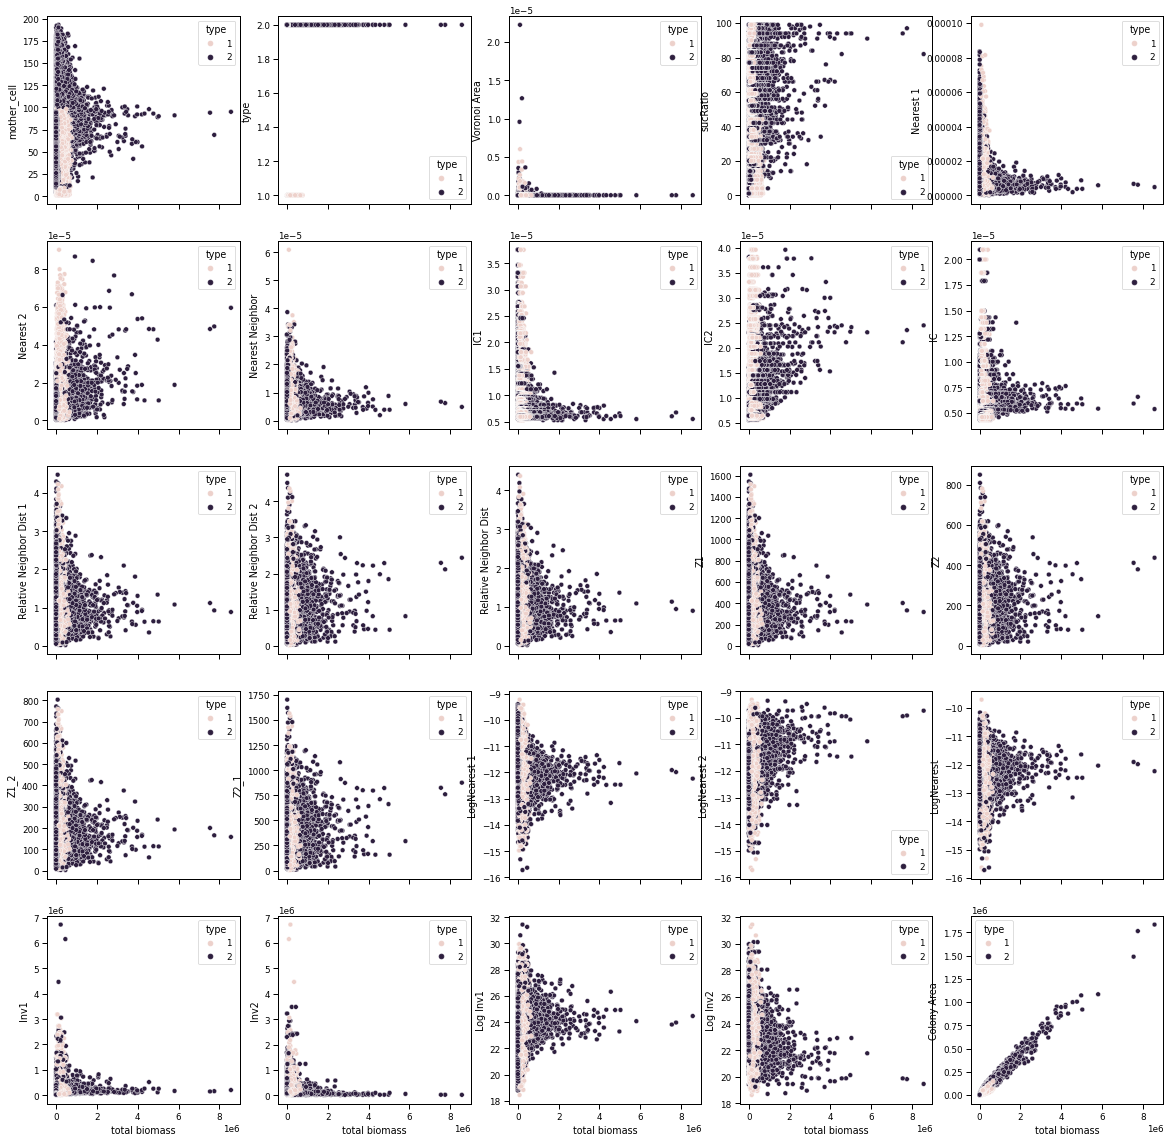

In [7]:

sns.set_context('paper')
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20),sharex=True)
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


# Define backward regression algorithm

In [8]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
threshold = 0.01

# Perform backward regression to find the best fitting parameters

In [9]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(data[stats], data['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Z1_2                           with p-value 0.84496
Drop Voronoi Area                   with p-value 0.817796
Drop Z2_1                           with p-value 0.678882
Drop LogNearest                     with p-value 0.54466
Drop mother_cell                    with p-value 0.0430634
Drop Relative Neighbor Dist 2       with p-value 0.292602


['type',
 'sucRatio',
 'Nearest 1',
 'Nearest 2',
 'Nearest Neighbor',
 'IC1',
 'IC2',
 'IC',
 'Relative Neighbor Dist 1',
 'Relative Neighbor Dist',
 'Z1',
 'Z2',
 'LogNearest 1',
 'LogNearest 2',
 'Inv1',
 'Inv2',
 'Log Inv1',
 'Log Inv2']

# Check the resulting fit

In [10]:
y = data['total biomass']
X = data[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     855.4
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:17:46   Log-Likelihood:            -1.1967e+06
No. Observations:               89353   AIC:                         2.393e+06
Df Residuals:                   89338   BIC:                         2.394e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
type                    

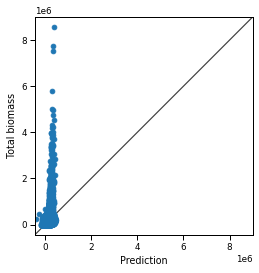

In [11]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# Regression with scaled metrics

In [12]:

scaler = StandardScaler()
metric_list = list(data.columns.drop(['total biomass','Colony Area']))
to_scale = list(data.columns)
scaled_df = data.copy()
scaled_df[to_scale] = scaler.fit_transform(data[to_scale])
scaled_df

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z1_2,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,-1.456872,-1.028577,-0.012473,-0.843963,0.830352,2.814503,0.303138,1.722689,2.239303,1.138575,...,1.058804,-0.447012,2.101436,0.644167,1.437373,-0.953398,-0.550636,-2.101436,-0.644167,0.843003
1,-1.306616,-1.028577,-0.003859,-0.843963,0.451822,0.730299,2.295901,2.614708,2.239303,1.138575,...,-0.486917,1.560670,0.995806,1.923359,1.852383,-0.685144,-0.918519,-0.995806,-1.923359,0.890568
2,-1.381744,-1.028577,-0.016660,-0.843963,0.878325,-0.187616,2.021395,0.610472,2.239303,1.138575,...,-1.167677,1.284110,0.078558,1.796778,0.751974,-0.270984,-0.893679,-0.078558,-1.796778,0.866799
3,-1.431830,-1.028577,-0.022484,-0.843963,-0.206953,-0.187616,1.654345,0.610472,2.239303,1.138575,...,-1.167677,0.914312,0.078558,1.610375,0.751974,-0.270984,-0.853369,-0.078558,-1.610375,-0.052890
4,-1.406787,-1.028577,-0.029447,-0.843963,0.499480,0.730299,0.292617,1.698945,2.239303,1.138575,...,-0.486917,-0.457611,0.995806,0.633839,1.425013,-0.685144,-0.546324,-0.995806,-0.633839,0.789089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,-1.406787,-1.028577,-0.028654,-1.547395,-0.008741,2.097442,-0.411476,0.109929,2.446571,-0.556491,...,0.412668,-0.096170,1.799553,-0.271834,0.341117,-0.897331,-0.037703,-1.799553,0.271834,0.477765
89,-1.281573,-1.028577,-0.029574,-1.547395,0.326911,0.589848,-0.964869,-1.138986,2.446571,-0.556491,...,-0.655932,-1.285835,0.885049,-1.714484,-1.385423,-0.646711,1.671019,-0.885049,1.714484,0.565417
90,-1.306616,-1.028577,-0.024288,-1.547395,0.135510,2.097442,-0.207912,0.569337,2.446571,-0.556491,...,0.412668,0.341444,1.799553,0.045846,0.721312,-0.897331,-0.249261,-1.799553,-0.045846,0.439499
91,-1.356701,-1.028577,-0.029533,-1.547395,1.479793,2.036895,-0.551798,-0.206754,2.446571,-0.556491,...,0.369751,-0.397828,1.771274,-0.533967,0.027401,-0.891521,0.171043,-1.771274,0.533967,1.646127


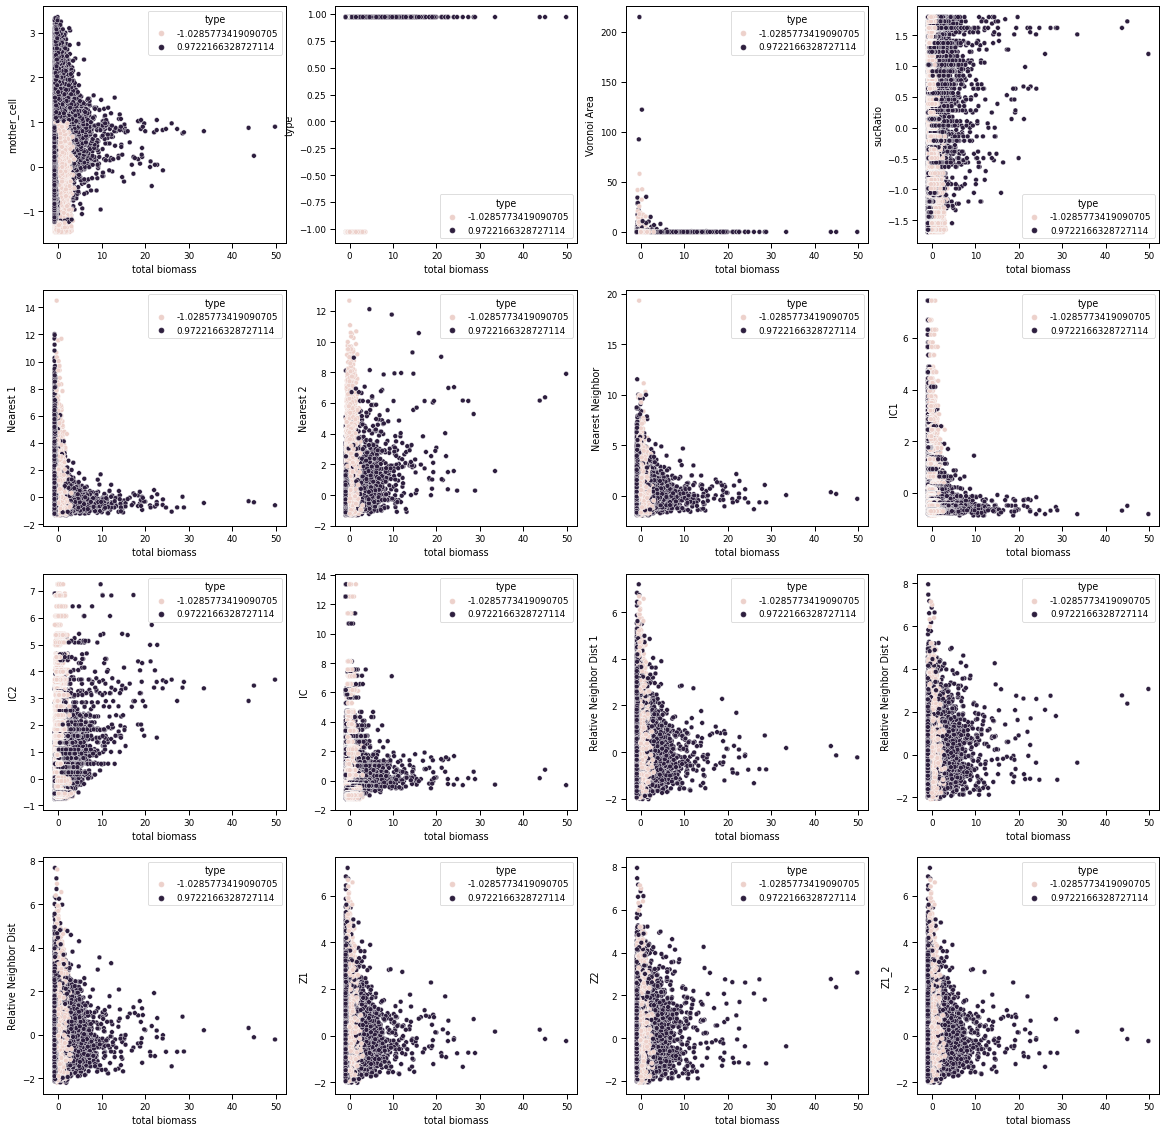

In [13]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20))
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=scaled_df,ax=ax)
plt.show()

In [14]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(scaled_df[stats], scaled_df['total biomass'], threshold_out=threshold,
                           verbose=True)


Drop Voronoi Area                   with p-value 0.810809
Drop Relative Neighbor Dist         with p-value 0.202185
Drop mother_cell                    with p-value 0.11968
Drop LogNearest                     with p-value 0.014177


In [15]:
y = scaled_df['total biomass']
X = scaled_df[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.118
Model:                            OLS   Adj. R-squared (uncentered):              0.118
Method:                 Least Squares   F-statistic:                              856.7
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                        0.00
Time:                        20:18:19   Log-Likelihood:                     -1.2116e+05
No. Observations:               89353   AIC:                                  2.423e+05
Df Residuals:                   89339   BIC:                                  2.425e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

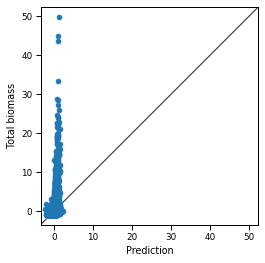

In [16]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# E. coli analysis

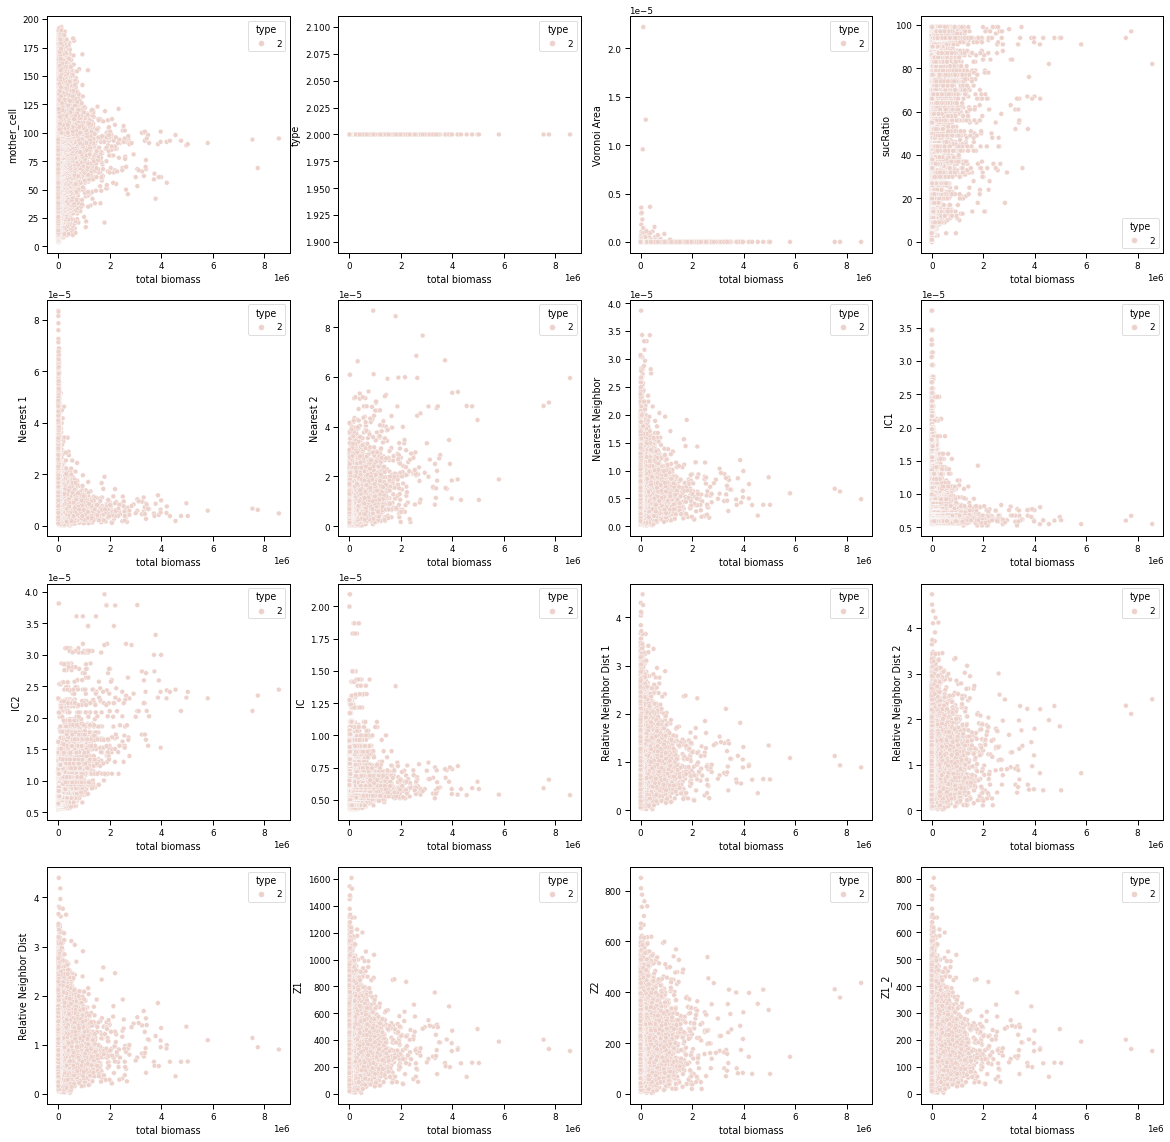

In [17]:
data2 = data[data.type==2]
stats = list(data2.columns.drop(['total biomass','Colony Area']))
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data2,ax=ax)
plt.show()

In [18]:
reg_mets = backward_regression(data2[stats], data2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Z2_1                           with p-value 0.979035
Drop Inv1                           with p-value 0.965529
Drop Voronoi Area                   with p-value 0.961173
Drop LogNearest 1                   with p-value 0.0585503
Drop Log Inv1                       with p-value 0.0354663


['mother_cell',
 'type',
 'sucRatio',
 'Nearest 1',
 'Nearest 2',
 'Nearest Neighbor',
 'IC1',
 'IC2',
 'IC',
 'Relative Neighbor Dist 1',
 'Relative Neighbor Dist 2',
 'Relative Neighbor Dist',
 'Z1',
 'Z2',
 'Z1_2',
 'LogNearest 2',
 'LogNearest',
 'Inv2',
 'Log Inv2']

In [19]:
y = data2['total biomass']
X = data2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     4017.
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:18:37   Log-Likelihood:            -6.1124e+05
No. Observations:               45935   AIC:                         1.223e+06
Df Residuals:                   45920   BIC:                         1.223e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
mother_cell             

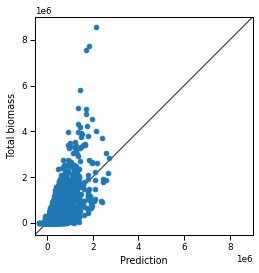

In [20]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [21]:
scaled_df2 = data2.copy()
scaled_df2[to_scale] = scaler.fit_transform(data2[to_scale])
scaled_df2

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z1_2,Z2_1,LogNearest 1,LogNearest 2,LogNearest,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
10,-1.913871,0.0,-0.025460,-0.839615,-0.290190,0.139938,1.905733,1.726159,1.648189,2.553968,...,-0.780214,0.418241,0.481938,1.634967,1.434164,-0.482669,-0.855965,-0.481938,-1.634967,0.005156
11,-1.557871,0.0,-0.014483,-0.839615,-0.375849,0.564455,1.905733,2.805451,1.648189,2.553968,...,-0.420503,0.418241,0.871150,1.634967,1.925639,-0.636711,-0.855965,-0.871150,-1.634967,-0.194490
12,-1.640025,0.0,-0.019409,-0.839615,-0.113147,2.977631,0.448209,1.367274,1.648189,2.553968,...,1.624280,-0.630225,2.133143,0.695045,1.238723,-0.936320,-0.554154,-2.133143,-0.695045,0.513542
13,-1.612640,0.0,-0.004642,-0.839615,-0.452663,2.249137,0.448209,1.367274,1.648189,2.553968,...,1.006997,-0.630225,1.848343,0.695045,1.238723,-0.888375,-0.554154,-1.848343,-0.695045,-0.245237
14,-1.941256,0.0,-0.013626,-0.839615,-0.441279,0.130539,-0.768274,-0.583749,1.648189,2.553968,...,-0.788178,-1.505300,0.472101,-0.839364,-0.424466,-0.478249,0.446664,-0.472101,0.839364,-0.343491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,-1.119717,0.0,-0.024155,-1.540779,-0.625807,5.106565,0.334660,1.185162,1.820804,-0.510191,...,3.186592,0.921172,2.750749,0.596114,1.131488,-1.014289,-0.512193,-2.750749,-0.596114,-0.750526
82,-0.873255,0.0,-0.024830,-1.540779,-0.621488,2.847297,2.073340,3.973696,1.820804,-0.510191,...,1.356953,3.589932,2.085908,1.717179,2.346642,-0.928969,-0.875595,-2.085908,-1.717179,-0.713818
83,-0.763717,0.0,-0.023810,-1.540779,-0.623353,4.333230,-0.146634,0.413251,1.820804,-0.510191,...,2.560317,0.182416,2.553875,0.103023,0.597014,-0.992739,-0.264778,-2.553875,-0.103023,-0.730355
84,-1.311410,0.0,-0.025132,-1.540779,-0.620022,5.411950,0.576995,1.573824,1.820804,-0.510191,...,3.433905,1.293140,2.822051,0.801020,1.353592,-1.021439,-0.596608,-2.822051,-0.801020,-0.716543


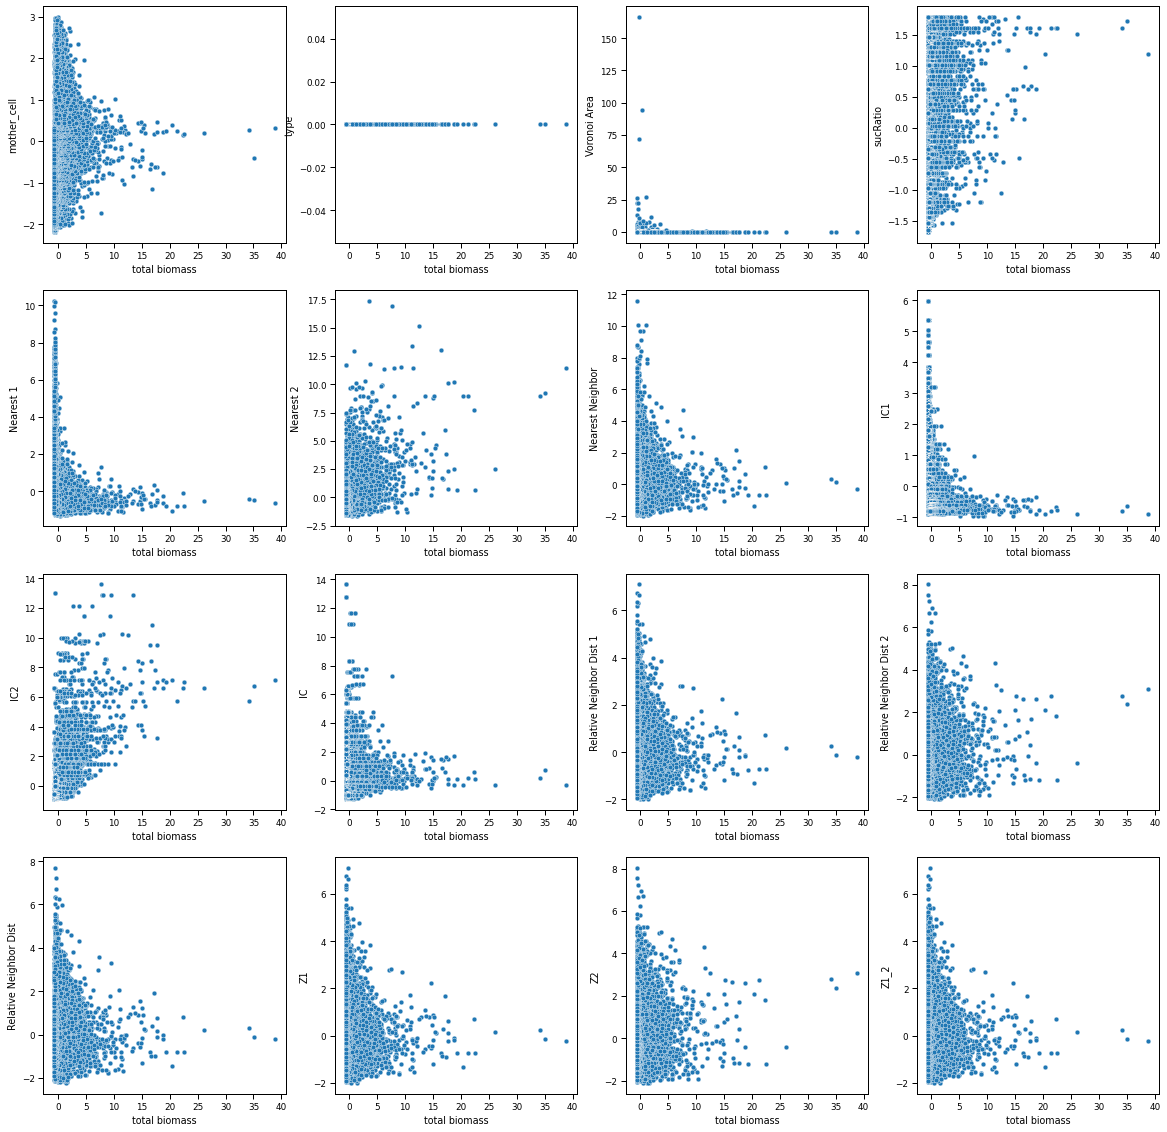

In [22]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,data=scaled_df2,ax=ax)
plt.show()

In [23]:
reg_mets = backward_regression(scaled_df2[stats], scaled_df2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Inv1                           with p-value 0.965525
Drop Voronoi Area                   with p-value 0.961172
Drop LogNearest 1                   with p-value 0.0354643
Drop Log Inv1                       with p-value 0.0354643


['mother_cell',
 'type',
 'sucRatio',
 'Nearest 1',
 'Nearest 2',
 'Nearest Neighbor',
 'IC1',
 'IC2',
 'IC',
 'Relative Neighbor Dist 1',
 'Relative Neighbor Dist 2',
 'Relative Neighbor Dist',
 'Z1',
 'Z2',
 'Z1_2',
 'Z2_1',
 'LogNearest 2',
 'LogNearest',
 'Inv2',
 'Log Inv2']

In [24]:
y = scaled_df2['total biomass']
X = scaled_df2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.550
Method:                 Least Squares   F-statistic:                              4017.
Date:                Sat, 18 Sep 2021   Prob (F-statistic):                        0.00
Time:                        20:18:43   Log-Likelihood:                         -46813.
No. Observations:               45935   AIC:                                  9.365e+04
Df Residuals:                   45921   BIC:                                  9.378e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

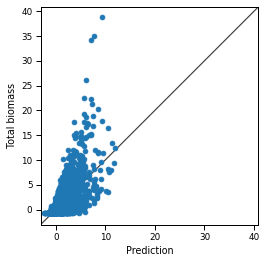

In [25]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [26]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 5, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

                     Feature  Rank
2                   sucRatio     1
4                  Nearest 2     1
7                        IC2     1
8                         IC     1
10  Relative Neighbor Dist 2     1


/software/dev_tools/swtree/cs400_centos7.2_pe2016-08/anaconda3/5.1.0/centos7.2_gnu6.3.0/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


5

In [27]:
lin_reg.fit(X,y)
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 -1.7843756780607484e-16
Coefficients: 
 [ 3.67079315e-02 -2.22044605e-16  2.57511163e-01  7.17022910e-02
  3.99885244e-01 -2.64175915e-01  3.00618942e-02  6.59981749e-01
 -5.16164076e-01 -2.91100720e-02 -9.73747458e-02  1.34820874e-01
 -2.91100720e-02 -9.73747458e-02 -2.91100720e-02 -9.73747458e-02
  5.60172122e-02  7.66757867e-02  5.57413244e-02 -5.60172122e-02]
